# COMP 527: Implementing the k-means clustering algorithm

> In the assignment, you are required to cluster words belonging to four categories: animals, countries, fruits and veggies. The words are arranged into four different files. The first entry in each line is a word followed by 300 features (word embedding) describing the meaning of that word.

## Implementation
 
> (1) Implement the k-means clustering algorithm with Euclidean distance to cluster the instances into k clusters. (30 marks)

In [4]:
import numpy as np    # for handling vectors
import pandas as pd    # for neatly displaying results in table
import matplotlib.pyplot as plt    # for plotting results

In [5]:
class Word():
    """Object class for a categorized word with data vector."""
    
    def __init__(self, name, vector, category):
        self.name = name
        self.vector = vector
        self.category = category
    
    def __repr__(self):
        return f'word: {self.name}'

In [6]:
def read_data(list_of_filenames):
    """Read in data."""

    collection = []

    for filename in list_of_filenames:
        data = open(filename).read().split('\n')[:-1]

        for word_data in data:
            split = word_data.split(' ')
            name = split[0]
            raw_list = split[1:]

            floats = []
            for x_string in raw_list:
                floats.append(float(x_string))

            vector = np.array(floats)

            collection.append( Word(name, vector, filename))

    return collection

In [7]:
categories = ['animals', 'countries', 'fruits', 'veggies']
words = read_data(categories)
print(len(words))

329


In [8]:
category = {}
for c in categories:
    category[c] = []
    for w in words:
        if w.category == c:
            category[c].append(w)
    print(c, len(category[c]))

animals 50
countries 161
fruits 58
veggies 60


In [9]:
for w in words:
    if w.vector.shape != words[0].vector.shape:
        print('ERROR', w)

In [10]:
words[0].vector[0:2]

array([-0.015926, -0.079864])

In [11]:
def flatten(data):
    """Return two-dimensional vectors."""

    flat = []

    for d in data:
        two_dim = d.vector[0:2]
        flat.append(Word(d.name, two_dim, d.category))

    return flat

In [12]:
flat = flatten(words)

In [13]:
flat[0].vector

array([-0.015926, -0.079864])

In [14]:
def euclidean_distance(u, v):
    """Return Euclidean distance between two np.array vectors."""

    return np.sqrt( (u - v).dot( u - v ))

In [15]:
def manhattan_distance(u, v):
    """Return Manhattan distance between two np.array vectors."""

    w = u - v
    distance = 0
    for x in w:
        distance += abs(x)
    
    return distance

In [16]:
def cosine_similarity(u, v):
    """Return Cosine similarity of two np.array vectors."""
    
    return u.dot(v)/( np.sqrt(u.dot(u)) * np.sqrt(v.dot(v)) )

In [17]:
def normalize(data):
    """Return normalized vectors (ie. parallel vector with unit magnitude)."""
    
    normalized_data = []
    
    for d in data:
        normalized_vector = d.vector / np.sqrt( d.vector.dot(d.vector) )
        normalized_data.append(Word(d.name, normalized_vector, d.category))
        
    return normalized_data

In [181]:
class KMeans():
    
    def __init__(
                self, 
                k = 4, 
                data = words, 
                metric = euclidean_distance, 
                norm = False, 
                max_iterations = 10**3, 
                seed = None,
                ):
        """
        Initialize KMeans Model.
        
        Args:
            k (int): number of clusters to divide data into.
            data (list): list of dicts which must each include
                the keys 'name' (string) and 'vector' (np.ndarray).
            metric (function): to measure distance between points.
            normalize (Boolean): whether or not to normalize vectors.
            iterations (int): when to stop if no convergence.
            seed (int): for reproducible (pseudo-)randomness.
        """
        
        self.k = k
        
        if normalize:
            self.data = normalize(data)
        else:
            self.data = data
        
        self.metric = metric
                
        if seed:
            np.random.seed(seed)
        
        # we track centroid positions and cluster labels in nested dicts,
        # of the form dict_name[iteration_number][centroid_number]
        self._centroid = {}
        
        self._cluster = {}

        # we record cluster labels explicitly as well
        self._label = {}
        
        self.max_iterations = max_iterations
        for i in range(self.max_iterations):
            self._iteration = i
            self._iterate()
            if i > 0 and self._cluster[i] == self._cluster[i-1]:
                break
        
        self.cluster = self._cluster[self._iteration]
        self.label = self._label[self._iteration]
        
        
        self._evaluate()
   
    def _start(self):
        """Shuffle dataset and position centroids on first k datapoints."""
        
        selected = np.random.permutation(self.data)[0:self.k]
        
        self._centroid[0] = {}
        
        for centroid_number in range(self.k):
            self._centroid[0][centroid_number] = selected[centroid_number].vector
           
    
    def _classify(self):
        """Assign each data point to cluster of nearest centroid."""
        
        self._cluster[self._iteration] = {}
        self._label[self._iteration] = {}
        
        for centroid_number in range(self.k):
            self._cluster[self._iteration][centroid_number] = []
        
        for d in self.data:
            distances = [] 
            
            for centroid_number in range(self.k):
                
                distances.append(self.metric(d.vector, self._centroid[self._iteration][centroid_number]))
            
            closest_centroid = np.argmin(distances)
            
            self._cluster[self._iteration][closest_centroid].append(d)
            self._label[self._iteration][d.name] = closest_centroid
        
            
    def _reposition(self):
        """Move centroids to mean of each cluster."""
        
        for centroid_number in range(self.k):
            self._centroid[self._iteration] = {}
        
        for centroid_number in range(self.k):
            
            clustered = self._cluster[self._iteration - 1][centroid_number]
            
            if len(clustered) > 0:
                vector_sum = np.zeros(len(clustered[0].vector))
                
                for datum in clustered:
                    vector_sum += datum.vector

                cluster_mean = vector_sum / len(clustered)

                self._centroid[self._iteration][centroid_number] = cluster_mean

            else:
                # nothing assigned to this cluster so position is unchanged
                self._centroid[self._iteration][centroid_number] = \
                        self._centroid[self._iteration - 1][centroid_number]
           
   
    def _iterate(self):
        """Position centroids and classify data by nearest centroid."""
        
        if self._iteration == 0:
            self._start()
        else:
            self._reposition()
        
        if self._iteration == self.max_iterations:
            self._stop()
        else:
            self._classify()
            
            
    def _evaluate(self):
        """Evaluate success of clustering."""
        
        self.true_positives = 0
        self.true_negatives = 0
        self.false_positives = 0
        self.false_negatives = 0
        
        D = self.data
        
        for i in range(len(D)):
            for j in range(i+1, len(D)):
                if D[i].category == D[j].category and self.label[D[i].name] == self.label[D[j].name]:
                    self.true_positives += 1
                if D[i].category != D[j].category and self.label[D[i].name] == self.label[D[j].name]:
                    self.false_positives += 1
                if D[i].category != D[j].category and self.label[D[i].name] != self.label[D[j].name]:
                    self.true_negatives += 1
                if D[i].category == D[j].category and self.label[D[i].name] != self.label[D[j].name]:
                    self.false_negatives += 1
                    
        
        self.precision = self.true_positives / (self.true_positives + self.false_positives)
        self.recall = self.true_positives / (self.true_positives + self.false_negatives)
        self.f_score = 2 * self.precision * self.recall / (self.precision + self.recall)
        
        self.score = f' Precision: {self.precision}.\n Recall: {self.recall}.\n F-Score: {self.f_score}.'
        

## Compute Precision, Recall, and F-Score

> (2) Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

,precision,recall,f-score
1,0.324857,1.000000,0.490403
2,0.651405,1.000000,0.788910
3,0.834296,0.996748,0.908316
4,0.961084,0.960920,0.961002
5,0.975158,0.924920,0.949375
6,0.962111,0.556310,0.704985
7,0.972855,0.523448,0.680663
8,0.970457,0.432907,0.598730
9,0.964851,0.361764,0.526224
10,0.960220,0.318120,0.477909


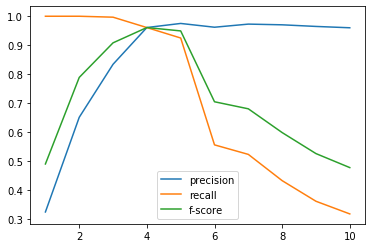

In [182]:
score = {}
for k in range(1,11):
    model = KMeans(k=k, seed=2)
    score[k] = {'precision':model.precision,'recall':model.recall,'f-score':model.f_score}
scores = pd.DataFrame(score).transpose()
scores.plot()
scores

## Normalize

> (3) Now re-run the k-means clustering algorithm you implemented in part (1) but normalise each feature vector to unit L2 length before computing Euclidean distances. Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

,precision,recall,f-score
1,0.324857,1.000000,0.490403
2,0.651405,1.000000,0.788910
3,0.834296,0.996748,0.908316
4,0.961084,0.960920,0.961002
5,0.975158,0.924920,0.949375
6,0.962111,0.556310,0.704985
7,0.972855,0.523448,0.680663
8,0.970457,0.432907,0.598730
9,0.964851,0.361764,0.526224
10,0.960220,0.318120,0.477909


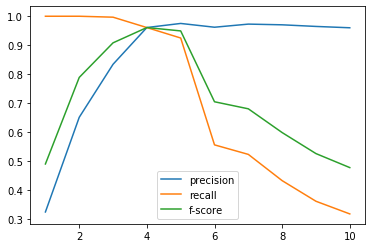

In [183]:
score = {}
for k in range(1,11):
    model = KMeans(k=k, norm=True, seed=2)
    score[k] = {'precision':model.precision,'recall':model.recall,'f-score':model.f_score}
scores = pd.DataFrame(score).transpose()
scores.plot()
scores

## Manhattan Distance

> (4) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance over the unnormalised feature vectors. Vary the value of k from 1 to 10
and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

,precision,recall,f-score
1,0.324857,1.000000,0.490403
2,0.651405,1.000000,0.788910
3,0.818763,0.963943,0.885442
4,0.969462,0.968964,0.969213
5,0.978633,0.930226,0.953816
6,0.965033,0.560532,0.709156
7,0.975955,0.523334,0.681324
8,0.970492,0.424064,0.590225
9,0.965086,0.356401,0.520562
10,0.951926,0.312928,0.471018


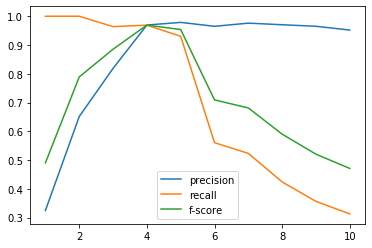

In [184]:
score = {}
for k in range(1,11):
    model = KMeans(k=k, metric=manhattan_distance, seed=2)
    score[k] = {'precision':model.precision,'recall':model.recall,'f-score':model.f_score}
scores = pd.DataFrame(score).transpose()
scores.plot()
scores

## Normalized Manhattan Distance

> (5) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance with L2 normalised feature vectors. Vary the value of k from 1 to 10 and
compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

,precision,recall,f-score
1,0.324857,1.000000,0.490403
2,0.651405,1.000000,0.788910
3,0.818763,0.963943,0.885442
4,0.969462,0.968964,0.969213
5,0.978633,0.930226,0.953816
6,0.965033,0.560532,0.709156
7,0.975955,0.523334,0.681324
8,0.970492,0.424064,0.590225
9,0.965086,0.356401,0.520562
10,0.951926,0.312928,0.471018


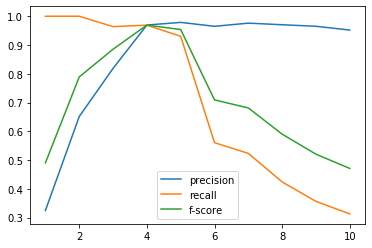

In [185]:
score = {}
for k in range(1,11):
    model = KMeans(k=k, metric=manhattan_distance, norm=True, seed=2)
    score[k] = {'precision':model.precision,'recall':model.recall,'f-score':model.f_score}
scores = pd.DataFrame(score).transpose()
scores.plot()
scores

##  Cosine Similarity

> (6) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use cosine similarity as the distance (similarity) measure.Vary the value of k from 1 to 10 andcompute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

In [ ]:
score = {}
for k in range(1,11):
    model = KMeans(k=k, metric=cosine_similarity, seed=2)
    score[k] = {'precision':model.precision,'recall':model.recall,'f-score':model.f_score}
scores = pd.DataFrame(score).transpose()
scores.plot()
scores

## Compare and Discuss

> (7) Comparing the different clusterings you obtained in (2)-(6) discuss what is the best setting for k-means clustering for this dataset. (20 marks)